# OmniFold Demo

In this tutorial, we showcase the OmniFold method for universally unfolding collider data using synthetic datasets of jets.

Unfolding is the problem of estimating the particle-level (`truth`) information from the measured detector-level data (`data`). The detector is imperfect and smears the particle-level radiation pattern, giving rise to the need to unfold, which is particularly important for jet substructure. OmniFold uses a synthetic dataset where the particle-level (`generation`) and detector-level (`simulation`) information are both known.

OmniFold is an iterative unfolding procedure consisting of two steps.
* First, the `simulation` is reweighted to the `data`.
* Second, the previous `generation` is reweighted to the new `generation`.

OmniFold results in a set of weights for the `generation` that reweight it to an estimate for the `truth` distribution.

### Imports

In [1]:
import sys
sys.path.append("../OmniFold")
sys.path.append("../unfolding")
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import pandas as pd

import modplot
import ibu
from bdt_omnifold import binned_omnifold
from bdt_omnifold import unbinned_omnifold 

### Plot Style

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

## Loading the Datasets

The datasets consists of jets that are produced in association with a $Z$ boson ($Z$+jet with $p_T^Z>200$ GeV).
Jets are clustered with the anti-$k_T$ algorithm with a radius of $R=0.4$ and the leading (highest $p_T$) jet is taken. This procedure is done with several tunes of Pythia and the default tune of Hergwig, both before and after passing through a DELPHES simulation of the CMS detector.

These samples are publicly available on [Zenodo](https://zenodo.org/record/3548091#.XdbOvjJKhlo), with automatic download and read-in provided by the [EnergyFlow](https://energyflow.network) Python package.

**Customize**: Read in `'Pythia21'` and `'Pythia25'` to explore other tunes. Change `num_data` to vary the amount of data, `-1` is the entire dataset.

In [3]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=100000, exclude_keys=['particles']),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=100000, exclude_keys=['particles'])}

## Specifying the Unfolding Problem

OmniFold requires particle-level event generators (here, Pythia or Herwig) as well as a faithful simulation of the detector (here, DELPHES). By default we will treat Herwig as the natural "truth"/"data" and Pythia as the synthetic "generation"/"simulation".

**Customize**: Change which tune of Pythia is used and which generator is used as `synthetic` or `nature`. Change plot stamps below accordingly.

In [4]:
# choose what is MC and Data in this context
synthetic, nature = datasets['Pythia26'], datasets['Herwig']

We also have to specify `itnum`: how many iterations of the unfolding procedure we want to do.

**Customize**: Change `itnum` to your desired number of unfolding iterations.

In [5]:
# how many iterations of the unfolding process
itnum = 3

There are three flavors of OmniFold. In order of increasing sophistication, they are:
* **UniFold**: Represent the jet as a single observable.
* **MultiFold**: Represent the jet as multiple observables.
* **OmniFold**: Represent the jet as a set of particles.

By default, we will implement MultiFold and represent the jet using six jet substructure observbles:
* `'Mass'`, Jet Mass $m$: the invaraiant mass of the jet four-vector
* `'Mult'`, Constituent Multiplicity $M$: the number of particles in the jet
* `'Width'`, Jet Width $w$: a measure of how broad the jet is
* `'Tau21'`, $N$-subjettiness Ratio $\tau_{21}$: a measure of how two-pronged the jet is
* `'zg'`, Groomed Momentum Fraction $z_g$: the energy-sharing of the prongs after grooming
* `'SDMass'`, Groomed Jet Mass $m_{\rm SD}$: the invariant mass of the jet four-vector after grooming

**Customize**: Change which observables are used in MultiFold. UniFold corresponds to using a single observable.

In [6]:
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']

The observables are already computed in the samples. We will read them in as an observable dictionary `obs` and also specify histogram style information.

**Customize**: Add entries to `obs` to define your own observables to be used in MultiFold or to see the unfolding performance on them.

In [7]:
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, ptype: np.log(dset[ptype + '_sdms']**2/
                                       dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

Now all that remains is to get the values of the specified observables and compute the histograms with the specified binnings. As an unfolding benchmark, we also obtain the unfolding results of Iterative Bayesian Unfolding (IBU) as implemented in `ibu.py`. The following cell takes care of all of these aspects.

In [8]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')

    print(ob['truthobs'].shape, ob['dataobs'].shape, ob['genobs'].shape, ob['simobs'].shape)
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

(100000,) (100000,) (100000,) (100000,)
Done with Mass
(100000,) (100000,) (100000,) (100000,)
Done with Mult
(100000,) (100000,) (100000,) (100000,)
Done with Width
(100000,) (100000,) (100000,) (100000,)
Done with Tau21
(100000,) (100000,) (100000,) (100000,)
Done with zg
(100000,) (100000,) (100000,) (100000,)
Done with SDMass


## Unbinned BDT OmniFold

In [9]:
mc_entries = np.asarray([obs[obkey]['genobs'] for obkey in obs_multifold])
sim_entries = np.asarray([obs[obkey]['simobs'] for obkey in obs_multifold])
measured_entries = np.asarray([obs[obkey]['dataobs'] for obkey in obs_multifold])
truth_entries = np.asarray([obs[obkey]['truthobs'] for obkey in obs_multifold])

pass_reco_mask = np.full((100000), True)
pass_truth_mask = np.full((100000), True)

print(mc_entries.shape, sim_entries.shape, measured_entries.shape, truth_entries.shape)



(6, 100000) (6, 100000) (6, 100000) (6, 100000)


In [10]:
unbinned_results = []

for i, _ in enumerate(obs_multifold):
    unbinned_results.append(
        unbinned_omnifold(mc_entries[i], sim_entries[i], measured_entries[i], pass_reco_mask, pass_truth_mask, itnum)
    )


Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2


# Binned BDT Omnifold

In [ ]:
def binned_unfold(response, measured_hist, MC_bins, MC_low, MC_high):
    binned_weights, MC_entries, _, _ = binned_omnifold(response, measured_hist, num_iterations)
    
    omnifold_MC_hist_binned, omnifold_MC_bin_edges_binned = np.histogram(
        MC_entries.flatten(), 
        weights=binned_weights[-1][1], 
        bins=MC_bins, 
        range=[MC_low, MC_high]
    )
    omnifold_MC_bin_centers_binned = (omnifold_MC_bin_edges_binned[:-1] + omnifold_MC_bin_edges_binned[1:]) / 2

    efficiencies = response.Vefficiency()
    efficiencies_np = np.empty(efficiencies.GetNoElements())

    for i in range(efficiencies.GetNoElements()):
        efficiencies_np[i] = efficiencies[i]

    omnifold_MC_hist_binned = np.divide(
        omnifold_MC_hist_binned, 
        efficiencies_np, 
        out=np.zeros_like(omnifold_MC_hist_binned, dtype=np.float32),
        where=(
            (efficiencies_np != 0) & 
            (~np.isnan(efficiencies_np)) & 
            (~np.isinf(efficiencies_np))
        )
    )
    return omnifold_MC_hist_binned, omnifold_MC_bin_centers_binned


binned_results = []
for i, _ in enumerate(obs_multifold):
    result = binned_unfold(response, measured_hist, bins, bins_low, bins_high)
    binned_results.append(result)

## Plot Unfolding Results

Now it's time to plot the unfolding results for all of the specified observables!

NameError: name 'of_histgen' is not defined

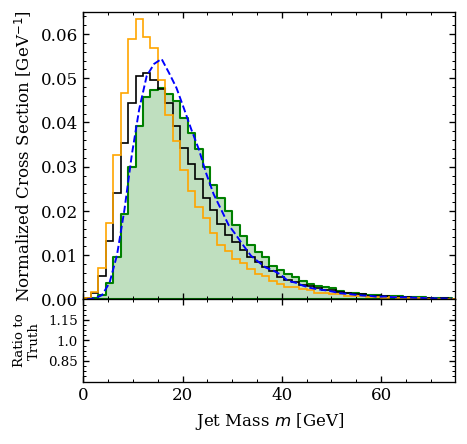

In [12]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # UNBINNED RESULTS
    unbinned_weights, MC_entries_unbinned, sim_entries_unbinned, pass_reco_mask_unbinned = unbinned_results[i]
    omnifold_sim_hist_unbinned, omnifold_sim_bin_edges_unbinned = np.histogram(
        MC_entries_unbinned.flatten(),
        weights=unbinned_weights[iteration_to_plot, 1],
        bins=bins[i][0],
        range=[bins[i][1], bins[i][2]]
    )
    omnifold_sim_bin_centers_unbinned = (omnifold_sim_bin_edges_unbinned[:-1] + omnifold_sim_bin_edges_unbinned[1:]) / 2



    

    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # plot the IBU distributio
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 5, 0, 1] if ncol==2 else [3, 5, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'\textbf{D/T}: \textsc{Herwig 7.1.5} default',
                  line_1=r'\textbf{S/G}: \textsc{Pythia 8.243} tune 26',
                  line_2=r'\textsc{Delphes 3.4.2} CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()